<a href="https://colab.research.google.com/github/tejaswishetty17/Agentic-AI/blob/main/Calling_Agents_2(Calling_Multiple_Agents).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ReAct Agent

*   act (let the model call specific tools)
*   observe (pass the tool output back to the model)
*   reason (let the model reason about the tool output and to decide what to do next)



In [1]:
pip install -q langchain langchain_openai langchain_community langgraph langchain-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.5/438.5 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 2.7 MB/s eta 0:00:00


In [2]:
import os
os.environ["OPENAI_API_KEY"] = "<YOUR_API_KEY>"

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = "gpt-4o-mini")

In [21]:
from langchain.tools import tool

@tool  #register as a tool
def multiply(a: int, b: int)-> int:
  """Multiply a and b.
  Args:
    a: first int
    b: second int
  """ #this is important for the llm to judge if it has to do a tool call when the tool is registered.
  return a * b

@tool
def add(a: int, b: int)-> int:
  """Adds a and b.
  Args:
    a: first int
    b: second int
  """
  return a + b

@tool
def divide(a: int, b: int)-> int:
  """Divide a and b.
  Args:
    a: first int
    b: second int
  """
  return a / b


llm_with_tools = llm.bind_tools([multiply, add, divide])

In [6]:
from langchain_core.messages import HumanMessage
result = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="User")])

In [ ]:
result.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_flz4XF5KrlDeLLg6VfACXOFe',
  'type': 'tool_call'}]

In [7]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
  #add any keys needed beyond this messages, which is pre-built
  pass

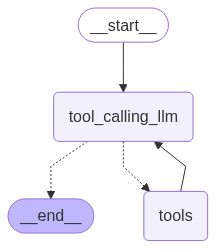

In [24]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

#Node
def tool_calling_llm(state: MessagesState):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

#Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply, add, divide]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # if the latest message from tool_calling_llm is a tool call -> tools_condition routes to tools node
    # if the latest message from tool_calling_llm is not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")
graph = builder.compile()

#View
display(Image(graph.get_graph().draw_mermaid_png()))

if we pass in a `user question`, the LLM responds without any toold calls.

In [12]:
messages = graph.invoke({"messages":HumanMessage(content="What is the use of LLM?")})

for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

What is the use of LLM?
================================== Ai Message ==================================

Large Language Models (LLMs) are powerful tools used for a variety of applications in natural language processing and artificial intelligence. Here are some common uses of LLMs:

1. **Text Generation**: LLMs can generate human-like text, making them useful for content creation, storytelling, and writing assistance.

2. **Translation**: They can be employed for translating text between different languages with a good degree of accuracy.

3. **Summarization**: LLMs can summarize long texts into concise versions, helping to distill information efficiently.

4. **Question Answering**: They can answer questions based on context or specific queries, which is useful for customer support and information retrieval.

5. **Conversational Agents**: Used in chatbots and virtual assistants, LLMs can engage users in

The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool

In [22]:
messages = graph.invoke({"messages":HumanMessage(content="Multiply 300 and 80. Multiply the output by 10")})

for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Multiply 300 and 80. Multiply the output by 10
================================== Ai Message ==================================
Tool Calls:
  multiply (call_0ameDN6IQKBp3dvLKWyfYZmd)
 Call ID: call_0ameDN6IQKBp3dvLKWyfYZmd
  Args:
    a: 300
    b: 80
================================= Tool Message =================================
Name: multiply

24000
================================== Ai Message ==================================
Tool Calls:
  multiply (call_AbzJpLMUNcsy8zpuvdZobmXn)
 Call ID: call_AbzJpLMUNcsy8zpuvdZobmXn
  Args:
    a: 24000
    b: 10
================================= Tool Message =================================
Name: multiply

240000
================================== Ai Message ==================================

The result of multiplying 300 and 80 is 24,000. When you multiply that by 10, the final output is 240,000.


In [25]:
messages = graph.invoke({"messages":HumanMessage(content="first add 10 and 20. Multiply the output by 20. Divide the result by 100")})

for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

first add 10 and 20. Multiply the output by 20. Divide the result by 100
================================== Ai Message ==================================
Tool Calls:
  add (call_FIpMpgwtVn471duQFLGaZZYM)
 Call ID: call_FIpMpgwtVn471duQFLGaZZYM
  Args:
    a: 10
    b: 20
================================= Tool Message =================================
Name: add

30
================================== Ai Message ==================================
Tool Calls:
  multiply (call_1k8WFIs9PQcD5dEeZQxyqDws)
 Call ID: call_1k8WFIs9PQcD5dEeZQxyqDws
  Args:
    a: 30
    b: 20
  divide (call_6zTEknVfuOkK7L67enzYcpHY)
 Call ID: call_6zTEknVfuOkK7L67enzYcpHY
  Args:
    a: 600
    b: 100
================================= Tool Message =================================
Name: multiply

600
================================= Tool Message =================================
Name: divide

6.0
================================== A